In [1]:
try:
    import google.colab

    IN_COLAB = True
except:
    IN_COLAB = False
if IN_COLAB:
    !pip install -q transformers
    from google.colab import drive

    drive.mount('/content/drive')
    import sys

    sys.path.append('/content/drive/MyDrive/gan_bert_for_cpv')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 105.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 34.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 121.6 MB/s eta 0:00:00
Mounted at /content/drive


In [3]:
from transformers import logging

logging.set_verbosity_error()
import torch
from create_dataset import CreateDataset
from process_data import ProcessData
from utils import *
from torch.utils.data import DataLoader
from run_model import RunModel
from models import BertGenerator, BertDiscriminator
from transformers import AutoTokenizer, AutoModel, AutoConfig

In [4]:
from models import *

In [5]:
Classifiers = [EmbeddingClassifier, HiddenClassifier1, HiddenClassifier2, HiddenClassifier3, HiddenClassifier4,
               HiddenClassifier5, HiddenClassifier6, HiddenClassifier7, HiddenClassifier8, HiddenClassifier9,
               HiddenClassifier10, HiddenClassifier11, HiddenClassifier12]

In [6]:
label_column = "afdeling"
text_column = "Korte beschrijving aanbesteding"
input_df = pd.read_csv("/content/drive/MyDrive/gan_bert_for_cpv/data/cleaned_dutch_ted1.csv")

In [7]:
vc = input_df[label_column].value_counts()
down_sample_vc = vc[vc.values < 1500]
input_df = input_df[input_df[label_column].isin(down_sample_vc.index)]

In [8]:
running_device = torch.device("cuda")

In [9]:
prd = ProcessData(input_df, label_column, text_column, sample_num=1000, aug_limit=1000, test_per_label_num=30,
                  drop_limit=50,
                  balanced_test=True)
suf_df,insuf_df,_, label_encoder, onehot = prd.process()
train_df = pd.read_csv("/content/drive/MyDrive/gan_bert_for_cpv/data/sampled_train.csv")
test_df = pd.read_csv("/content/drive/MyDrive/gan_bert_for_cpv/data/sampled_test.csv")
suf_df, insuf_df = prd._split_sufficient_insufficient(train_df)

After removing duplicate sentence: 16897
After drop cpv with low observations we have : 16803
The num of class is  30
The number of total data is:  15992
Total number of test data is:  900
Total number of train data is:  15092


In [10]:
value_counts = insuf_df[label_column].value_counts()
model_runner = RunModel(running_device)

In [11]:
train_df[label_column].value_counts()

Furniture (incl. Meubelen (m.i.v. kantoormeubelen), inrichtingsartikelen, huishoudelijke apparaten (uitgez. verlichting) en schoonmaakproducten    970
Medische apparatuur, farmaceutische artikelen en artikelen voor lichaamsverzorging                                                                 970
Aardolieproducten, brandstof, elektriciteit en andere energiebronnen                                                                               970
Vervoersdiensten (uitg. vervoer van afval)                                                                                                         921
Diensten voor onderwijs en opleiding                                                                                                               841
Radio-, televisie-, communicatie-, telecommunicatietoestellen en aanverwante apparatuur                                                            816
Overige gemeenschaps-,  sociale en persoonlijke diensten                                      

In [12]:
tokenizer = AutoTokenizer.from_pretrained("GroNLP/bert-base-dutch-cased")
config = AutoConfig.from_pretrained("GroNLP/bert-base-dutch-cased", output_hidden_states=True)
bert = AutoModel.from_pretrained("GroNLP/bert-base-dutch-cased", config=config).to(running_device)

In [13]:
aug_limits = decide_aug_labels(True, 970, value_counts,0.5)

In [14]:
aug_limits

{'Vervoersdiensten (uitg. vervoer van afval)': 49,
 'Diensten voor onderwijs en opleiding': 129,
 'Radio-, televisie-, communicatie-, telecommunicatietoestellen en aanverwante apparatuur': 154,
 'Overige gemeenschaps-,  sociale en persoonlijke diensten': 177,
 'Laboratoriuminstrumenten, optische en precisie-instrumenten (uitgezonderd brillen)': 188,
 'Structuren en materialen voor de bouw; ondersteunende producten voor de bouw (uitgezonderd elektrische apparatuur)': 201,
 'Onderzoek en ontwikkeling, en aanverwante adviezen': 217,
 'Bedrijfsmachines': 231,
 'Post- en telecommunicatiediensten': 329,
 'Drukwerk en aanverwante producten': 404,
 'Kleding, schoeisel, bagageartikelen en accessoires': 422,
 'Diensten voor openbaar bestuur, defensie en sociale verzekering': 432,
 'Uitrusting voor veiligheid, brandweer, politie en leger': 537,
 'Cultuur-, sport- en recreatiediensten': 570,
 'Diensten voor hotel, restaurant en detailhandel': 571,
 'Elektrische machines, apparaten, uitrusting en v

In [15]:
cd = CreateDataset(text_column, label_column, label_encoder, onehot, 0, running_device, max_length=120)
test_dataset = cd.create(test_df)
test_dl = DataLoader(test_dataset, shuffle=True, batch_size=20)
insuf_ds_dict = cd.create_label_dataset(insuf_df)
insuf_ds_list = list(insuf_ds_dict.values())
train_dataset = torch.utils.data.ConcatDataset(insuf_ds_list)
train_dl = DataLoader(train_dataset, shuffle=True, batch_size=20)
classifier = PretrainClassifier(prd.num_class, bert)
classifier = model_runner.train_classifier(train_dl, test_dl, classifier, lr=1e-5, n_epochs=6)
predictions, labels = model_runner.predict(test_dl, classifier)
acc, f1, precision, recall, label_f1 = evaluate(labels, predictions)

100%|██████████| 755/755 [04:58<00:00,  2.53it/s]


0 train loss:  3.3057826515854587 val acc:  0.0666666679084301


100%|██████████| 755/755 [04:58<00:00,  2.53it/s]


1 train loss:  2.6876961240705275 val acc:  0.3200000022020605


100%|██████████| 755/755 [04:58<00:00,  2.53it/s]


2 train loss:  1.7885608394414383 val acc:  0.42777778489722146


100%|██████████| 755/755 [04:58<00:00,  2.53it/s]


3 train loss:  1.3008260300617345 val acc:  0.4933333449893528


100%|██████████| 755/755 [04:58<00:00,  2.53it/s]


4 train loss:  1.0260128679654457 val acc:  0.5333333465788099


100%|██████████| 755/755 [04:58<00:00,  2.53it/s]


5 train loss:  0.8383893791018733 val acc:  0.563333347108629
Total ACC: 0.563
F1: 0.502
Precision: 0.471
Recall: 0.563


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [16]:
bert_2 = AutoModel.from_pretrained("GroNLP/bert-base-dutch-cased", config=config).to(running_device)

In [17]:
ACCs = []
F1s = []
Precisions = []
Recalls = []
Label_f1s = []
for layer_index in range(13):
    cd = CreateDataset(text_column, label_column, label_encoder, onehot, layer_index, running_device, max_length=120)
    test_dataset = cd.create(test_df)
    test_dl = DataLoader(test_dataset, shuffle=True, batch_size=20)
    insuf_ds_dict = cd.create_label_dataset(insuf_df)
    insuf_ds_list = list(insuf_ds_dict.values())
    augmented_ds_lists = model_runner.augment_data(bert, aug_limits, insuf_ds_dict)
    gan_aug_train_dataset = torch.utils.data.ConcatDataset(augmented_ds_lists + insuf_ds_list)
    gan_train_dl = DataLoader(gan_aug_train_dataset, shuffle=True, batch_size=20)
    Classifier = Classifiers[layer_index]
    classifier = Classifier(prd.num_class, bert_2)
    classifier = model_runner.train_classifier(gan_train_dl, test_dl, classifier, lr=1e-5, n_epochs=6)
    predictions, labels = model_runner.predict(test_dl, classifier)
    acc, f1, precision, recall, label_f1 = evaluate(labels, predictions)
    ACCs.append(acc)
    F1s.append(f1)
    Precisions.append(precision)
    Recalls.append(recall)
    Label_f1s.append(label_f1)

Getting bert hidden states from layer: 0: 100%|██████████| 538/538 [00:06<00:00, 80.67it/s]


We have: 27 labels to be augmented


100%|██████████| 1444/1444 [09:31<00:00,  2.53it/s]


0 train loss:  2.1412815756662402 val acc:  0.49333334101570975


100%|██████████| 1444/1444 [09:30<00:00,  2.53it/s]


1 train loss:  0.9421390632033306 val acc:  0.551111121972402


100%|██████████| 1444/1444 [09:30<00:00,  2.53it/s]


2 train loss:  0.6853736724389763 val acc:  0.5900000115235646


100%|██████████| 1444/1444 [09:30<00:00,  2.53it/s]


3 train loss:  0.558392713971209 val acc:  0.6066666781902313


100%|██████████| 1444/1444 [09:32<00:00,  2.52it/s]


4 train loss:  0.4364936745724282 val acc:  0.6222222328186036


100%|██████████| 1444/1444 [09:31<00:00,  2.53it/s]


5 train loss:  0.3163887476719467 val acc:  0.6333333518770006


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.633
F1: 0.616
Precision: 0.648
Recall: 0.633


Getting bert hidden states from layer: 1: 100%|██████████| 538/538 [00:06<00:00, 78.37it/s]


We have: 27 labels to be augmented


100%|██████████| 1444/1444 [08:43<00:00,  2.76it/s]


0 train loss:  2.336440263445027 val acc:  0.42666667368676925


100%|██████████| 1444/1444 [08:43<00:00,  2.76it/s]


1 train loss:  1.0834677988493047 val acc:  0.5488889025317298


100%|██████████| 1444/1444 [08:41<00:00,  2.77it/s]


2 train loss:  0.734116567314249 val acc:  0.5777777910232544


100%|██████████| 1444/1444 [08:41<00:00,  2.77it/s]


3 train loss:  0.5885950991821958 val acc:  0.5844444559680091


100%|██████████| 1444/1444 [08:41<00:00,  2.77it/s]


4 train loss:  0.4837016059115395 val acc:  0.5855555673440297


100%|██████████| 1444/1444 [08:41<00:00,  2.77it/s]


5 train loss:  0.40899193788416827 val acc:  0.6144444617960189


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.614
F1: 0.573
Precision: 0.581
Recall: 0.614


Getting bert hidden states from layer: 2: 100%|██████████| 538/538 [00:06<00:00, 78.58it/s]


We have: 27 labels to be augmented


100%|██████████| 1444/1444 [07:54<00:00,  3.04it/s]


0 train loss:  2.099038015937541 val acc:  0.4544444537825055


100%|██████████| 1444/1444 [07:54<00:00,  3.04it/s]


1 train loss:  0.8006380266120394 val acc:  0.6122222390439775


100%|██████████| 1444/1444 [07:54<00:00,  3.04it/s]


2 train loss:  0.5021570066139721 val acc:  0.6200000140402052


100%|██████████| 1444/1444 [07:54<00:00,  3.05it/s]


3 train loss:  0.36052614061672683 val acc:  0.6266666809717815


100%|██████████| 1444/1444 [07:53<00:00,  3.05it/s]


4 train loss:  0.2589430829408189 val acc:  0.6411111248864068


100%|██████████| 1444/1444 [07:54<00:00,  3.04it/s]


5 train loss:  0.18551055583335366 val acc:  0.6444444570276472


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.644
F1: 0.623
Precision: 0.665
Recall: 0.644


Getting bert hidden states from layer: 3: 100%|██████████| 538/538 [00:06<00:00, 79.29it/s]


We have: 27 labels to be augmented


100%|██████████| 1444/1444 [07:04<00:00,  3.40it/s]


0 train loss:  2.1857663333581097 val acc:  0.4577777875794305


100%|██████████| 1444/1444 [07:04<00:00,  3.40it/s]


1 train loss:  0.9071205934184575 val acc:  0.5811111271381378


100%|██████████| 1444/1444 [07:04<00:00,  3.40it/s]


2 train loss:  0.5424881552751086 val acc:  0.6166666772630479


100%|██████████| 1444/1444 [07:04<00:00,  3.40it/s]


3 train loss:  0.3791595776578272 val acc:  0.630000012450748


100%|██████████| 1444/1444 [07:04<00:00,  3.40it/s]


4 train loss:  0.2759559985257974 val acc:  0.6377777887715234


100%|██████████| 1444/1444 [07:04<00:00,  3.40it/s]


5 train loss:  0.19652989702499174 val acc:  0.6500000132454766


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.650
F1: 0.632
Precision: 0.685
Recall: 0.650


Getting bert hidden states from layer: 4: 100%|██████████| 538/538 [00:06<00:00, 80.77it/s]


We have: 27 labels to be augmented


100%|██████████| 1444/1444 [06:16<00:00,  3.83it/s]


0 train loss:  2.121194018819821 val acc:  0.45222223301728565


100%|██████████| 1444/1444 [06:17<00:00,  3.83it/s]


1 train loss:  0.8221211225939837 val acc:  0.573333344856898


100%|██████████| 1444/1444 [06:18<00:00,  3.82it/s]


2 train loss:  0.5325542383200368 val acc:  0.5977777944670783


100%|██████████| 1444/1444 [06:17<00:00,  3.83it/s]


3 train loss:  0.3887011992804438 val acc:  0.632222232553694


100%|██████████| 1444/1444 [06:17<00:00,  3.83it/s]


4 train loss:  0.2826694891313375 val acc:  0.638888900147544


100%|██████████| 1444/1444 [06:17<00:00,  3.83it/s]


5 train loss:  0.20126253629581864 val acc:  0.6488888998826344


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.649
F1: 0.632
Precision: 0.675
Recall: 0.649


Getting bert hidden states from layer: 5: 100%|██████████| 538/538 [00:06<00:00, 79.10it/s]


We have: 27 labels to be augmented


100%|██████████| 1444/1444 [05:28<00:00,  4.40it/s]


0 train loss:  2.1270027914370857 val acc:  0.4577777882417043


100%|██████████| 1444/1444 [05:28<00:00,  4.40it/s]


1 train loss:  0.8841956365347899 val acc:  0.551111121972402


100%|██████████| 1444/1444 [05:28<00:00,  4.39it/s]


2 train loss:  0.6347081750538458 val acc:  0.6055555668142106


100%|██████████| 1444/1444 [05:27<00:00,  4.40it/s]


3 train loss:  0.4960665964338299 val acc:  0.6088889042536417


100%|██████████| 1444/1444 [05:27<00:00,  4.41it/s]


4 train loss:  0.39162727020980165 val acc:  0.6077777948644426


100%|██████████| 1444/1444 [05:27<00:00,  4.41it/s]


5 train loss:  0.3150801778515579 val acc:  0.6244444529215495


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.624
F1: 0.595
Precision: 0.633
Recall: 0.624


Getting bert hidden states from layer: 6: 100%|██████████| 538/538 [00:06<00:00, 81.92it/s]


We have: 27 labels to be augmented


100%|██████████| 1444/1444 [04:39<00:00,  5.16it/s]


0 train loss:  2.122420534821759 val acc:  0.47222223281860354


100%|██████████| 1444/1444 [04:39<00:00,  5.17it/s]


1 train loss:  0.8696374152516146 val acc:  0.5511111206478543


100%|██████████| 1444/1444 [04:39<00:00,  5.17it/s]


2 train loss:  0.5728150616036186 val acc:  0.6088889035913679


100%|██████████| 1444/1444 [04:39<00:00,  5.17it/s]


3 train loss:  0.41954931000459145 val acc:  0.6133333464463552


100%|██████████| 1444/1444 [04:39<00:00,  5.16it/s]


4 train loss:  0.32214905957270856 val acc:  0.632222232553694


100%|██████████| 1444/1444 [04:39<00:00,  5.16it/s]


5 train loss:  0.23145046494217522 val acc:  0.6211111267407735


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.621
F1: 0.596
Precision: 0.627
Recall: 0.621


Getting bert hidden states from layer: 7: 100%|██████████| 538/538 [00:06<00:00, 80.31it/s]


We have: 27 labels to be augmented


100%|██████████| 1444/1444 [03:53<00:00,  6.18it/s]


0 train loss:  2.1495522068312956 val acc:  0.45000000761614906


100%|██████████| 1444/1444 [03:53<00:00,  6.18it/s]


1 train loss:  0.8648569157496714 val acc:  0.5544444574250116


100%|██████████| 1444/1444 [03:53<00:00,  6.18it/s]


2 train loss:  0.5965579803259089 val acc:  0.5711111260784997


100%|██████████| 1444/1444 [03:53<00:00,  6.18it/s]


3 train loss:  0.44954624331435006 val acc:  0.5955555684036679


100%|██████████| 1444/1444 [03:53<00:00,  6.18it/s]


4 train loss:  0.3381061676129895 val acc:  0.6111111263434092


100%|██████████| 1444/1444 [03:53<00:00,  6.18it/s]


5 train loss:  0.24675777785246547 val acc:  0.6244444575574662


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.624
F1: 0.605
Precision: 0.641
Recall: 0.624


Getting bert hidden states from layer: 8: 100%|██████████| 538/538 [00:06<00:00, 78.70it/s]


We have: 27 labels to be augmented


100%|██████████| 1444/1444 [03:04<00:00,  7.81it/s]


0 train loss:  2.1863341817730353 val acc:  0.44333334068457286


100%|██████████| 1444/1444 [03:04<00:00,  7.83it/s]


1 train loss:  1.0485500869833944 val acc:  0.5266666783226861


100%|██████████| 1444/1444 [03:04<00:00,  7.82it/s]


2 train loss:  0.8182147456142133 val acc:  0.5466666791174147


100%|██████████| 1444/1444 [03:04<00:00,  7.81it/s]


3 train loss:  0.6846701986442766 val acc:  0.5755555695957608


100%|██████████| 1444/1444 [03:04<00:00,  7.83it/s]


4 train loss:  0.5221551736607797 val acc:  0.5855555686685774


100%|██████████| 1444/1444 [03:04<00:00,  7.81it/s]


5 train loss:  0.41276836741671813 val acc:  0.596666677792867


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.597
F1: 0.560
Precision: 0.551
Recall: 0.597


Getting bert hidden states from layer: 9: 100%|██████████| 538/538 [00:06<00:00, 82.37it/s]


We have: 27 labels to be augmented


100%|██████████| 1444/1444 [02:17<00:00, 10.51it/s]


0 train loss:  2.1955434764191053 val acc:  0.3766666723622216


100%|██████████| 1444/1444 [02:17<00:00, 10.50it/s]


1 train loss:  1.004836232233741 val acc:  0.5277777903609806


100%|██████████| 1444/1444 [02:17<00:00, 10.51it/s]


2 train loss:  0.7550304206423565 val acc:  0.56111112303204


100%|██████████| 1444/1444 [02:17<00:00, 10.51it/s]


3 train loss:  0.634823563059797 val acc:  0.5600000136428409


100%|██████████| 1444/1444 [02:17<00:00, 10.51it/s]


4 train loss:  0.5418473983214461 val acc:  0.574444458882014


100%|██████████| 1444/1444 [02:17<00:00, 10.51it/s]


5 train loss:  0.4634141366731458 val acc:  0.5844444559680091


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.584
F1: 0.541
Precision: 0.535
Recall: 0.584


Getting bert hidden states from layer: 10: 100%|██████████| 538/538 [00:06<00:00, 79.45it/s]


We have: 27 labels to be augmented


100%|██████████| 1444/1444 [01:29<00:00, 16.22it/s]


0 train loss:  2.3329724866762716 val acc:  0.3544444508022732


100%|██████████| 1444/1444 [01:28<00:00, 16.24it/s]


1 train loss:  1.1262550361021073 val acc:  0.4633333434661229


100%|██████████| 1444/1444 [01:28<00:00, 16.26it/s]


2 train loss:  0.8673210241044987 val acc:  0.5277777903609806


100%|██████████| 1444/1444 [01:28<00:00, 16.26it/s]


3 train loss:  0.727695859065718 val acc:  0.5455555690659417


100%|██████████| 1444/1444 [01:28<00:00, 16.27it/s]


4 train loss:  0.6410341599641414 val acc:  0.5700000140402052


100%|██████████| 1444/1444 [01:28<00:00, 16.25it/s]


5 train loss:  0.5663181345528018 val acc:  0.5577777889039781


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.558
F1: 0.517
Precision: 0.520
Recall: 0.558


Getting bert hidden states from layer: 11: 100%|██████████| 538/538 [00:06<00:00, 80.53it/s]


We have: 27 labels to be augmented


100%|██████████| 1444/1444 [00:43<00:00, 33.21it/s]


0 train loss:  2.6046494128301205 val acc:  0.17666667103767394


100%|██████████| 1444/1444 [00:43<00:00, 33.28it/s]


1 train loss:  1.4989311689939195 val acc:  0.3755555633041594


100%|██████████| 1444/1444 [00:43<00:00, 33.25it/s]


2 train loss:  1.1837573258459073 val acc:  0.44111112025049


100%|██████████| 1444/1444 [00:43<00:00, 33.22it/s]


3 train loss:  1.0699661787589005 val acc:  0.46222223341464996


100%|██████████| 1444/1444 [00:43<00:00, 33.19it/s]


4 train loss:  0.9972823640883712 val acc:  0.46666667693191105


100%|██████████| 1444/1444 [00:43<00:00, 33.21it/s]


5 train loss:  0.9426211174216297 val acc:  0.4811111218399472


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.481
F1: 0.417
Precision: 0.396
Recall: 0.481


Getting bert hidden states from layer: 12: 100%|██████████| 538/538 [00:06<00:00, 80.88it/s]


We have: 27 labels to be augmented


100%|██████████| 1444/1444 [00:06<00:00, 228.80it/s]


0 train loss:  2.9716436234702694 val acc:  0.05333333445919885


100%|██████████| 1444/1444 [00:06<00:00, 238.60it/s]


1 train loss:  2.285232118539863 val acc:  0.08555555732713806


100%|██████████| 1444/1444 [00:06<00:00, 228.71it/s]


2 train loss:  2.040570711825363 val acc:  0.1255555579231845


100%|██████████| 1444/1444 [00:06<00:00, 236.94it/s]


3 train loss:  1.8703472729039654 val acc:  0.14444444725910824


100%|██████████| 1444/1444 [00:06<00:00, 228.84it/s]


4 train loss:  1.7871082913429783 val acc:  0.16333333609832656


100%|██████████| 1444/1444 [00:06<00:00, 237.65it/s]


5 train loss:  1.7275514854659995 val acc:  0.1700000042716662
Total ACC: 0.170
F1: 0.119
Precision: 0.111
Recall: 0.170


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


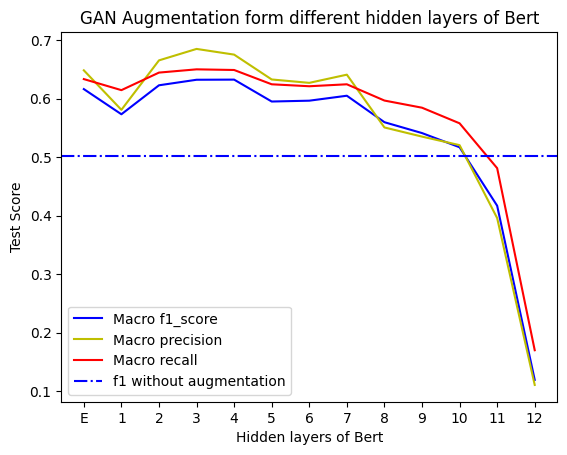

In [19]:
x_label=["E"]+[i for i in range(1,13)]
import matplotlib.pyplot as plt
# plt.plot(ACCs, label="accuracy")
fig = plt.figure(edgecolor='k', frameon=True)
# fig.patch.set_facecolor('xkcd:blue')
plt.plot(F1s, label="Macro f1_score",color='b')
plt.plot(Precisions, label="Macro precision",color='y')
plt.plot(Recalls, label="Macro recall",color='r')
# plt.text(x, y, s, fontdict=None, **kwargs)[source]

plt.axhline(y = 0.502, color = 'b', linestyle = 'dashdot',label="f1 without augmentation")
plt.xticks([i for i in range(13)],x_label)
plt.xlabel("Hidden layers of Bert")
plt.ylabel("Test Score")
plt.title("GAN Augmentation form different hidden layers of Bert")
plt.legend()
plt.show()

In [20]:
all_fls=np.array(Label_f1s)

In [21]:
print(all_fls)

[[0.69565217 0.33962264 0.79245283 0.8        0.82142857 0.77419355
  0.67647059 0.84210526 0.         0.63333333 0.11538462 0.84745763
  0.55072464 0.75409836 0.83018868 0.0625     0.75409836 0.59375
  0.43902439 0.73333333 0.47272727 0.58064516 0.30769231 0.73015873
  0.86956522 0.71428571 0.52631579 0.60273973 0.90322581 0.72413793]
 [0.74626866 0.49275362 0.76666667 0.53488372 0.79310345 0.74285714
  0.70175439 0.88135593 0.56140351 0.60869565 0.16666667 0.85714286
  0.54285714 0.69565217 0.84210526 0.         0.         0.53521127
  0.18181818 0.         0.5        0.63492063 0.26666667 0.64788732
  0.90909091 0.75409836 0.45544554 0.75362319 0.88235294 0.74193548]
 [0.75       0.33333333 0.83018868 0.75       0.8        0.75362319
  0.66666667 0.84210526 0.65454545 0.6031746  0.11764706 0.84745763
  0.52873563 0.72413793 0.87272727 0.         0.76470588 0.53521127
  0.27027027 0.74193548 0.56603774 0.62295082 0.18181818 0.6779661
  0.89230769 0.67647059 0.46341463 0.67857143 0.86

In [22]:
label_encoder.inverse_transform([i for i in range(prd.num_class)])

array(['Aardolieproducten, brandstof, elektriciteit en andere energiebronnen',
       'Bedrijfsmachines', 'Chemische producten',
       'Cultuur-, sport- en recreatiediensten',
       'Diensten voor hotel, restaurant en detailhandel',
       'Diensten voor onderwijs en opleiding',
       'Diensten voor openbaar bestuur, defensie en sociale verzekering',
       'Drukwerk en aanverwante producten',
       'Elektrische machines, apparaten, uitrusting en verbruiksartikelen. Verlichting',
       'Furniture (incl. Meubelen (m.i.v. kantoormeubelen), inrichtingsartikelen, huishoudelijke apparaten (uitgez. verlichting) en schoonmaakproducten',
       'Installatiediensten (uitgezonderd software)',
       'Kleding, schoeisel, bagageartikelen en accessoires',
       'Laboratoriuminstrumenten, optische en precisie-instrumenten (uitgezonderd brillen)',
       'Landbouw- en veeteelt-, kwekerij-, visserij-, bosbouw- en aanverwante producten',
       'Landbouwmachines',
       'Machines voor de mijnbou

In [24]:
for i in range(prd.num_class):
    label=label_encoder.inverse_transform([i])
    print(list(all_fls[:,i]))
    print(value_counts[label])

[0.6956521739130435, 0.746268656716418, 0.7500000000000001, 0.8000000000000002, 0.6857142857142857, 0.7058823529411765, 0.78125, 0.7868852459016393, 0.5, 0.6571428571428571, 0.6176470588235295, 0.5116279069767441, 0.1806451612903226]
Aardolieproducten, brandstof, elektriciteit en andere energiebronnen    970
Name: afdeling, dtype: int64
[0.339622641509434, 0.4927536231884058, 0.3333333333333333, 0.35514018691588783, 0.42105263157894735, 0.35443037974683544, 0.29850746268656714, 0.37209302325581395, 0.3225806451612903, 0.3764705882352941, 0.3764705882352941, 0.3, 0.19565217391304346]
Bedrijfsmachines    739
Name: afdeling, dtype: int64
[0.7924528301886793, 0.7666666666666667, 0.8301886792452831, 0.8301886792452831, 0.8571428571428571, 0.7666666666666667, 0.7719298245614035, 0.7307692307692307, 0.8571428571428571, 0.8070175438596491, 0.6938775510204083, 0.7058823529411764, 0.0]
Chemische producten    167
Name: afdeling, dtype: int64
[0.8, 0.5348837209302325, 0.75, 0.7407407407407408, 0.7

In [ ]:
cd = CreateDataset(text_column, label_column, label_encoder, onehot, 0, running_device, max_length=120)
test_dataset = cd.create(test_df)
test_dl = DataLoader(test_dataset, shuffle=True, batch_size=20)
insuf_ds_dict = cd.create_label_dataset(insuf_df)
insuf_ds_list = list(insuf_ds_dict.values())
train_dataset = torch.utils.data.ConcatDataset(insuf_ds_list)
train_dl = DataLoader(train_dataset, shuffle=True, batch_size=20)
Classifier = Classifiers[0]
classifier = Classifier(prd.num_class, bert)
classifier = model_runner.train_classifier(train_dl, test_dl, classifier, lr=1e-5, n_epochs=6)
predictions, labels = model_runner.predict(test_dl, classifier)
acc, f1, precision, recall, label_f1 = evaluate(labels, predictions)

100%|██████████| 755/755 [05:05<00:00,  2.47it/s]


0 train loss:  3.1997555467466645 val acc:  0.28777778281105887


100%|██████████| 755/755 [05:05<00:00,  2.47it/s]


1 train loss:  2.0998171910544894 val acc:  0.4266666756735908


100%|██████████| 755/755 [05:05<00:00,  2.47it/s]


2 train loss:  1.4319441424300339 val acc:  0.49555556211206647


100%|██████████| 755/755 [05:05<00:00,  2.47it/s]


3 train loss:  1.0823064050137603 val acc:  0.5255555669466655


100%|██████████| 755/755 [05:05<00:00,  2.47it/s]


4 train loss:  0.8565918920253286 val acc:  0.5455555674102571


100%|██████████| 755/755 [05:05<00:00,  2.47it/s]


5 train loss:  0.7038976163362826 val acc:  0.536666684018241
Total ACC: 0.537
F1: 0.473
Precision: 0.440
Recall: 0.537


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
